# Import dependencies

In [1]:
from abc import ABC, abstractmethod

import random
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from dataclasses import dataclass

import torch
from torch import nn
from torch.distributions import Categorical
import torch.nn.functional as F

import scipy
import scipy.ndimage

from tqdm.notebook import tqdm
import easyrl.models.diag_gaussian_policy as DiagGaussian

In [2]:
def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

# set random seed
seed = 0
set_random_seed(seed=seed)

# Set default parameters

In [3]:
def getDefaultParams():
    # here goes the default parameters for the agent
    config = dict(
        # env=env, the agent does not need to ahve access to the env because there is an engine
        learning_rate=0.00025,
        gamma=0.99,
        memory_size=200000,
        initial_epsilon=1.0,
        min_epsilon=0.1,
        max_epsilon_decay_steps=150000,
        warmup_steps=500,
        target_update_freq=2000,
        batch_size=32,
        device=None,
        disable_target_net=False,
        enable_double_q=False,
        use_gae=False,
        train_ac_iters=5,
        target_kl=0.01,
        clip_ratio=0.2,
        entropy_coef=0.01,
        use_critic=True
    )
    return config

# Create categorical policy network

In [4]:
# Stolen from easyrl Categorical policy policy with some modifications
class CategoricalPolicy(nn.Module):
    def __init__(self,
                 body_net,
                 action_dim,
                 in_features=None,
                 ):
        super().__init__()
        self.body = body_net
        if in_features is None:
            for i in reversed(range(len(self.body.fcs))):
                layer = self.body.fcs[i]
                if hasattr(layer, 'out_features'):
                    in_features = layer.out_features
                    break

        self.head = nn.Sequential(nn.Linear(in_features, action_dim), nn.Softmax())

    def forward(self, x=None, body_x=None, **kwargs):
        if x is None and body_x is None:
            raise ValueError('One of [x, body_x] should be provided!')
        if body_x is None:
            body_x = self.body(x, **kwargs)
        if isinstance(body_x, tuple):
            pi = self.head(body_x[0])
        else:
            pi = self.head(body_x)
        action_dist = Categorical(probs=pi)
        return action_dist, body_x

# Create backbone NN structure

In [5]:
def init_params(m):
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)

class WhoNetwork(nn.Module):
    def __init__(self, input_dim, action_dim):
        super().__init__()
        #### A simple network that takes
        #### as input the history, and outputs the 
        #### distribution parameters.
        self.fcs = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
        )
        self.out_layer = nn.Sequential(nn.Linear(32, action_dim), nn.Sigmoid())
            
    def forward(self, ob):
        x = self.fcs(ob)
        preds = self.out_layer(x)
        return preds
            
class NNetwork(nn.Module):
    def __init__(self, input_dim, action_dim, final_activation=None, use_critic=False):
        self.final_activation = final_activation
        self.use_critic = use_critic
        super().__init__()
        #### A simple network that takes
        #### as input the history, and outputs the 
        #### distribution parameters.
        self.fcs = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU())
        self.out_layer = nn.Sequential(nn.Linear(64, action_dim))
        
        # Define critic's model
        if self.use_critic:
            self.critic = nn.Sequential(
                nn.Linear(input_dim, 128),
                nn.ReLU(),
                nn.Linear(128, 32),
                nn.Tanh(),
                nn.Linear(32, 1)
            )
        
        # Set initial weights and biases
        self.apply(init_params)

    def forward(self, ob):
        mid_logits = self.fcs(ob)
        logits = self.out_layer(mid_logits)
        if self.final_activation is not None:
            logits = self.final_activation(logits, dim=-1)
        if self.use_critic:
            return logits, self.critic(ob)
        else:
            return logits, None


# Define game parameters and NN initialization

In [8]:
RED_TEAM_ID = 1
BLUE_TEAM_ID = 0
NUM_PLAYERS = 5
RED_PLAYERS = 2
BLUE_PLAYERS = 3
HIST_SHAPE = 2 * 25 * (3 * NUM_PLAYERS + 5)
SELF_SHAPE = torch.tensor([5])
COMM_SHAPE = 32  # Change freely
WHO_SHAPE = NUM_PLAYERS
VOTE_SHAPE =torch.tensor([NUM_PLAYERS])
BADNESS_SHAPE = WHO_SHAPE

assert RED_PLAYERS + BLUE_PLAYERS == NUM_PLAYERS

def get_who():
    return WhoNetwork(SELF_SHAPE + HIST_SHAPE + BADNESS_SHAPE + NUM_PLAYERS*COMM_SHAPE, WHO_SHAPE)

def get_comm(use_critic=False):
    return DiagGaussian.DiagGaussianPolicy(NNetwork(SELF_SHAPE + HIST_SHAPE + WHO_SHAPE, torch.tensor([64]), use_critic=use_critic), COMM_SHAPE, in_features=torch.tensor([64]))

def get_miss(mission_shapes = (10,10), use_critic=False):
    model = NNetwork(SELF_SHAPE + WHO_SHAPE + HIST_SHAPE, 64, use_critic=use_critic)
    return [CategoricalPolicy(model, mish, 64) for mish in mission_shapes]

def get_vote(use_critic=False):
    return CategoricalPolicy(NNetwork(HIST_SHAPE + SELF_SHAPE + WHO_SHAPE, 128, use_critic=use_critic), 2, 128)

def get_succ(use_critic=False):
    return CategoricalPolicy(NNetwork(HIST_SHAPE + SELF_SHAPE + WHO_SHAPE, 128,use_critic=use_critic), 2, 128)

@torch.no_grad()
def miss_players(miss):
    # 0: 0,1
    # 1: 0,2
    # 2: 0,3
    # 3: 0,4
    # 4: 1,2
    # 5: 1,3
    # 6: 1,4
    # 7: 2,3
    # 8: 2,4
    # 9: 3,4
    miss_cat = torch.zeros(NUM_PLAYERS)
    if miss<4:
        miss_cat[0] = 1
        miss_cat[miss+1] = 1
    elif miss<7:
        miss_cat[1] = 1
        miss_cat[miss-2] = 1
    elif miss<9:
        miss_cat[2] = 1
        miss_cat[miss-4] = 1
    else:
        miss_cat[3] = 1
        miss_cat[miss-5] = 1
    return miss_cat

def model_lookup(train_model, red_agent, blue_agent):
    table = {"comm_red": (red_agent.COMM, red_agent.COMM_opt),
        "miss_red_2" : (red_agent.MISS, red_agent.MISS_opt2),
        "miss_red_3" : (red_agent.MISS, red_agent.MISS_opt3),
        "vote_red" : (red_agent.VOTE, red_agent.VOTE_opt), 
        "succ_red" : (red_agent.SUCC, red_agent.SUCC_opt),
        "who_blue" : (blue_agent.WHO, blue_agent.WHO_opt),
        "comm_blue" : (blue_agent.COMM, blue_agent.COMM_opt),
        "miss_blue_2" : (blue_agent.MISS, blue_agent.MISS_opt2),
        "miss_blue_3" : (blue_agent.MISS, blue_agent.MISS_opt3),
        "vote_blue" : (blue_agent.VOTE, blue_agent.VOTE_opt)}
    return table[train_model]

# Agent class

In [9]:
@dataclass
class Agent(ABC):
    
    @abstractmethod
    def comm():
        pass

    @abstractmethod
    def who():
        pass

    @abstractmethod
    def miss():
        pass

    @abstractmethod
    def vote():
        pass

    @abstractmethod
    def succ():
        pass

class RedAgent():

    def __init__(self, lrs, use_critic):
        self.lrs = lrs
        self.use_critic = use_critic

        self.COMM = get_comm(use_critic = use_critic)
#         self.who = (lambda *args : every)
        mission_models = get_miss(use_critic = use_critic)
        self.MISS = (lambda args : [mission_models[i](args) for i in range(2)])
        self.VOTE = get_vote(use_critic = use_critic)
        self.SUCC = get_succ(use_critic = use_critic)
        
        # Optimizers
        self.COMM_opt = torch.optim.Adam(self.COMM.parameters(), lr=lrs['COMM'])
        self.MISS_opt2 = torch.optim.Adam(mission_models[0].parameters(), lr=lrs['MISS2'])
        self.MISS_opt3 = torch.optim.Adam(mission_models[1].parameters(), lr=lrs['MISS3'])
        self.VOTE_opt = torch.optim.Adam(self.VOTE.parameters(), lr=lrs['VOTE'])
        self.SUCC_opt = torch.optim.Adam(self.SUCC.parameters(), lr=lrs['SUCC'])

class BlueAgent():
    
    def __init__(self, lrs, use_critic):
        self.lrs = lrs
        self.use_critic = use_critic

        self.COMM = get_comm(use_critic=use_critic)
        self.WHO = get_who()
        mission_models = get_miss(use_critic=use_critic)
        self.MISS = (lambda args : [mission_models[i](args) for i in range(2)])
        self.VOTE = get_vote(use_critic=use_critic)
#         self.succ = (lambda *args : torch.distributions.bernoulli.Bernoulli(1))
        
        # Optimizers
        self.COMM_opt = torch.optim.Adam(self.COMM.parameters(), lr=lrs['COMM'])
        self.WHO_opt = torch.optim.Adam(self.WHO.parameters(), lr=lrs['WHO'])
        self.MISS_opt2 = torch.optim.Adam(mission_models[0].parameters(), lr=lrs['MISS2'])
        self.MISS_opt3 = torch.optim.Adam(mission_models[1].parameters(), lr=lrs['MISS3'])
        self.VOTE_opt = torch.optim.Adam(self.VOTE.parameters(), lr=lrs['VOTE'])
    
    

In [376]:
# Baseline agents
class ConstantDistribution():
#   A "distribution" that always returns the same result when sampled

    def __init__(self, values):
#       Values must support element-wise comparison with ==
        self.values = values
    
    def sample(self):
        return self.values
    
    def log_prob(self, actions):
        return self.values == actions

class RedAgentBaseline():
    # this red agent takes actions according to the following rules:
    # COMM - outputs a random vector
    # MISS - always randomly choose 1 red player and 1~2 blue players (according to how many players go on mission)
    # VOTE - always vote yes if there are one or more red players on the mission, else no
    # SUCC - always fail the mission

    def __init__(self, use_critic, lr = 0.01):
#         self.COMM = (lambda args: (ConstantDistribution(torch.rand((COMM_SHAPE))), None))
        self.COMM = get_comm(use_critic = use_critic)
        
        # Optimizers
        self.COMM_opt = None
        self.MISS_opt2 = None
        self.MISS_opt3 = None
        self.VOTE_opt = None
        self.SUCC_opt = None

    def SUCC(self, obs):
        if len(obs.shape) == 1:
            return Categorical(probs=torch.Tensor([1])), None
        else:
            return Categorical(probs=torch.ones((obs.shape[0],1))), None
    
    def VOTE(self, obs):
        if len(obs.shape) == 1:
            # obs = SELF_SHAPE + EVERY_SHAPE + (HIST_SHAPE) <- who goes on mission is here
            # env.hist = torch.zeros((2, 25, 20))
            every = obs[SELF_SHAPE:SELF_SHAPE+WHO_SHAPE]
            hist = obs[SELF_SHAPE+WHO_SHAPE:]
            hist = hist.reshape((2, 25, len(hist) // 50))
            
            # find the LAST VALID mission combination
            miss = hist[0, hist[1, :, 5].sum().long()-1, 5:10]
            probs = torch.Tensor([0, 1]) if (miss[every == RED_TEAM_ID].sum()).sum() > 0 else torch.Tensor([1, 0])

            return Categorical(probs=probs), None
        else:
            # obs = EPISODES, SELF_SHAPE + EVERY_SHAPE + (HIST_SHAPE) <- who goes on mission is here
            
            probs_multi = []
            for ob in obs:            
                # env.hist = torch.zeros((2, 25, 20))
                every = ob[SELF_SHAPE:SELF_SHAPE+WHO_SHAPE]
                hist = ob[SELF_SHAPE+WHO_SHAPE:]
                hist = hist.reshape((2, 25, len(hist) // 50))

                # find the LAST VALID mission combination
                miss = hist[0, hist[1, :, 5].sum().long()-1, 5:10]
                probs = torch.Tensor([0, 1]) if (miss[every == RED_TEAM_ID].sum()).sum() > 0 else torch.Tensor([1, 0])

                probs_multi.append(probs)
            
            return Categorical(torch.stack(probs_multi,axis=0)), None
                
#                 return Categorical(probs=probs), None
            

    def MISS(self, obs):
        if len(obs.shape) == 1:
            # obs = SELF_SHAPE + EVERY_SHAPE + HIST_SHAPE
            every = obs[SELF_SHAPE:SELF_SHAPE+WHO_SHAPE]
            
            misses = []
            for num_pl_miss in [2, 3]:
                seq = np.arange(math.comb(NUM_PLAYERS, num_pl_miss))
                np.random.shuffle(seq)
                for comb in seq:
                    miss = miss_players(comb) if num_pl_miss == 2 else 1 - miss_players(comb)
                    if (every[miss.numpy().astype(bool)] == RED_TEAM_ID).sum() == 1:
                        break
                assert (every[miss.numpy().astype(bool)] == RED_TEAM_ID).sum() == 1
                misses.append(torch.Tensor([comb]))

            return (ConstantDistribution(misses[0]), None), \
                    (ConstantDistribution(misses[1]), None)
        else:
            # obs = EPISODES, SELF_SHAPE + EVERY_SHAPE + HIST_SHAPE
            misses_multi = [[],[]]
            
            for ob in obs:
                # obs = SELF_SHAPE + EVERY_SHAPE + HIST_SHAPE
                every = ob[SELF_SHAPE:SELF_SHAPE+WHO_SHAPE]

                for num_pl_miss in [2, 3]:
                    seq = np.arange(math.comb(NUM_PLAYERS, num_pl_miss))
                    np.random.shuffle(seq)
                    for comb in seq:
                        miss = miss_players(comb) if num_pl_miss == 2 else 1 - miss_players(comb)
                        if (every[miss.numpy().astype(bool)] == RED_TEAM_ID).sum() == 1:
                            break
                    assert (every[miss.numpy().astype(bool)] == RED_TEAM_ID).sum() == 1
                    
                    misses_multi[num_pl_miss-2].append(torch.Tensor([comb]))
            
            misses_multi[0] = ConstantDistribution(torch.concat(misses_multi[0]))
            misses_multi[1] = ConstantDistribution(torch.concat(misses_multi[1]))
                    
            return (misses_multi[0], None), (misses_multi[1], None)
            

def badness_factor(obs):
    # Takes in input to who model.
    self_v = obs[0:SELF_SHAPE]
    _comm_v = obs[SELF_SHAPE:COMM_SHAPE*NUM_PLAYERS]
    hist = obs[SELF_SHAPE+COMM_SHAPE*NUM_PLAYERS:]
    hist = hist.reshape((2, 25, len(hist) // 50))

    # Create badness score
    previous_mission_players = hist[0, :, 5:10]
#         previous_mission_successes = np.argmax(hist[1, :, 15:18], axis=-1)
    # 0 -> no mission
    # 1 -> success
    # 2 -> failure
    mission_no_result = hist[0, :, 15] == 1
    mission_failures = hist[0, :, 17] == 1

    # Number of missions each player was on minus the missions with no result
    total_previous_mission_players = torch.sum(previous_mission_players, dim=0) - \
                    torch.sum(previous_mission_players * mission_no_result.reshape(25,1), dim=0)
    # Number of mission each player was on that failed
    previous_mission_failures_players = torch.sum(previous_mission_players * mission_failures.reshape(25,1), dim=0)

    # Badness = Number_of_failed_missions_you_were_on / number_of_missions_you_were_on
    badness_score = previous_mission_failures_players / total_previous_mission_players
    # In the case where someone has never been on a mission, this will result in a nan
    # We will fill nans with 0.5.
    badness_score = torch.nan_to_num(badness_score, nan=0.5)

    # We know that I am blue
    badness_score[np.argmax(self_v)] = 0

#     self.who_v = badness_score

    return badness_score    

class BlueAgentBaseline():
    # this blue agent has a PRETRAINED WHO NETWORK and takes actions according to the following rules:
    # COMM - outputs a random vector
    # MISS - always choose itself and 1~2 other players PREDICTED TO BE BLUE THE MOST
    # VOTE - according to the 3 MOST POSSIBLE BLUE PLAYER,
    #        vote yes if the mission consist of only blue players, else no

    def __init__(self):
#         self.COMM = lambda args: (ConstantDistribution(torch.rand((COMM_SHAPE))), None)
        self.COMM = get_comm(use_critic = use_critic)
        
        self.COMM_opt = None
        self.WHO_opt = None
        self.MISS_opt2 = None
        self.MISS_opt3 = None
        self.VOTE_opt = None
        
        self.who_v = torch.zeros(NUM_PLAYERS)
    
    def VOTE(self, obs):
        # obs = SELF_SHAPE + WHO_SHAPE + (HIST_SHAPE) <- who goes on mission is here
        # env.hist = torch.zeros((2, 25, 20))
        hist = obs[SELF_SHAPE+WHO_SHAPE:]
        hist = hist.reshape((2, 25, len(hist) // 50))
        # find the LAST VALID mission combination
        # -- hist[1, si, 5:10]
        miss = hist[0, hist[1, :, 5].sum().long()-1, 5:10]
        
        reds = np.argsort(self.who_v)[-RED_PLAYERS:]
        
        yes = int(miss[reds].sum()==0)
        
        return Categorical(probs=torch.Tensor([1-yes, yes])), None

    def MISS(self, obs):        
        blues = np.argsort(self.who_v)[:BLUE_PLAYERS]
        
        miss2_v = torch.zeros(NUM_PLAYERS)
        miss3_v = torch.zeros(NUM_PLAYERS)
        miss2_v[blues[:2]] = 1
        miss3_v[blues[:3]] = 1
        miss2 = torch.Tensor([-1])
        miss3 = torch.Tensor([-1])
        
        for i in range(math.comb(NUM_PLAYERS, 2)):            
            if (miss_players(i) == miss2_v).sum() == NUM_PLAYERS:
                miss2 = torch.Tensor([i])
            if (1.0 - miss_players(i) == miss3_v).sum() == NUM_PLAYERS:
                miss3 = torch.Tensor([i])
                
        assert miss2 != -1 and miss3 != -1
        
        return (ConstantDistribution(miss2), None), (ConstantDistribution(miss3), None)
    
    def WHO(self, obs):
#         obs = obs.numpy()
        return obs[len(obs)-5:]
        

        

class BlueAgentBaselineWHO():
    # this blue agent has a PRETRAINED WHO NETWORK and takes actions according to the following rules:
    # COMM - outputs a random vector
    # MISS - always choose itself and 1~2 other players PREDICTED TO BE BLUE THE MOST
    # VOTE - according to the 3 MOST POSSIBLE BLUE PLAYER,
    #        vote yes if the mission consist of only blue players, else no

    def __init__(self, lrs, use_critic):
#         self.COMM = lambda args: (ConstantDistribution(torch.rand((COMM_SHAPE))), None)
        self.COMM = get_comm(use_critic = use_critic)
        
        self.WHO = get_who()
        self.COMM_opt = None
        self.WHO_opt = torch.optim.Adam(self.WHO.parameters(), lr=lrs['WHO'])
        self.MISS_opt2 = None
        self.MISS_opt3 = None
        self.VOTE_opt = None
        
    
    def VOTE(self, obs):
        # obs = SELF_SHAPE + WHO_SHAPE + (HIST_SHAPE) <- who goes on mission is here
        # env.hist = torch.zeros((2, 25, 20))
        hist = obs[SELF_SHAPE+WHO_SHAPE:]
        hist = hist.reshape((2, 25, len(hist) // 50))
        # find the LAST VALID mission combination
        # -- hist[1, si, 5:10]
        miss = hist[0, hist[1, :, 5].sum().long()-1, 5:10]
        who_v = obs[SELF_SHAPE:SELF_SHAPE+WHO_SHAPE].detach().numpy()
        reds = np.argsort(who_v)[-RED_PLAYERS:]
        
        yes = int(miss[reds].sum()==0)
        return Categorical(probs=torch.Tensor([1-yes, yes])), None

    def MISS(self, obs):        
        who_v = obs[SELF_SHAPE:SELF_SHAPE+WHO_SHAPE].detach().numpy()
        blues = np.argsort(who_v)[:BLUE_PLAYERS]
        
        miss2_v = torch.zeros(NUM_PLAYERS)
        miss3_v = torch.zeros(NUM_PLAYERS)
        miss2_v[blues[:2]] = 1
        miss3_v[blues[:3]] = 1
        miss2 = torch.Tensor([-1])
        miss3 = torch.Tensor([-1])
        
        for i in range(math.comb(NUM_PLAYERS, 2)):            
            if (miss_players(i) == miss2_v).sum() == NUM_PLAYERS:
                miss2 = torch.Tensor([i])
            if (1.0 - miss_players(i) == miss3_v).sum() == NUM_PLAYERS:
                miss3 = torch.Tensor([i])
                
        assert miss2 != -1 and miss3 != -1
        
        return (ConstantDistribution(miss2), None), (ConstantDistribution(miss3), None)
        
        

# Game environment definition

In [11]:
class AvalonEnv():
    def __init__(self):
        super().__init__()
        self.nm = [2, 3, 2, 3, 3, 0]
        self.reset()
    
    def reset(self):
        self.mi = 0
        self.ri = 0
        self.si = 0
        self.li = 0
        self.hist = torch.zeros((2, 25, 20))
        every = [0, 0, 0, 1, 1]
        random.shuffle(every)
        self.every = torch.Tensor(every.copy())        
        self.who = torch.normal(0.5, 0.1, (NUM_PLAYERS, NUM_PLAYERS))
        self.done = False
        self.winning_team = None
        
        # the initial observation of "hist" is all zeros
        # EXCEPT a one at the leader id (self.li) location of the zero-th step
        self.hist[0, 0, self.li] = 1
        self.hist[1, 0, :5] = 1
        
        return self.get_observation()
    
    def get_observation(self):         
        return self.hist, self.every, self.who, self.li, self.si, self.mi, self.nm[self.mi], self.done
    
    def update_who(self, who_m):
        self.who = who_m
        
    def update_miss(self, miss):
        # save to self.hist
        self.hist[0, self.si, 5:10] = miss.detach()
        self.hist[1, self.si, 5:10] = 1
        return self.hist
    
    def update_vote(self, vote):
        # save to self.hist
        self.hist[0, self.si, 10:15] = vote
        self.hist[1, self.si, 10:15] = 1
        
        # check if there are more yeses than noes
        if (vote >= 0.5).sum() > 2:
            # set relevance of only the no mission flag
            self.hist[1, self.si, 15] = 1
        else:
            # set the no mission flag
            self.hist[0, self.si, 15] = 1

            # set the current round
            self.hist[0, self.si, 19] = self.ri
            
            # set the number of failures
            self.hist[0, self.si, 18] = self.hist[0, self.si-1, 18] if self.si else 0
            
            # set relevance
            self.hist[1, self.si, 15:] = 1
            
            if self.ri == 4:
                # game is over, red team wins
                self.winning_team = RED_TEAM_ID
                self.done = True
                
            # update step id
            self.si += 1
                
            # update leader
            self.li = (self.li + 1) % 5
            self.hist[0, self.si, self.li] = 1
            self.hist[1, self.si, :5] = 1
            
            # update round id
            self.ri = (self.ri+1) % 5
            
            
        return self.hist
        
    def update_succ(self, succ):
        # set the current round
        self.hist[0, self.si, 19] = self.ri
        
        # set relevance
        self.hist[1, self.si, 16:] = 1
        
        if (succ < 0.5).sum():
            # set the mission failure flag
            self.hist[0, self.si, 17] = 1
            
            # set the number of failures
            self.hist[0, self.si, 18] = self.hist[0, self.si-1, 18] + 1 if self.si else 1
        else:
            # set the mission success flag
            self.hist[0, self.si, 16] = 1
            
            # set the number of failures
            self.hist[0, self.si, 18] = self.hist[0, self.si-1, 18] if self.si else 0
        
        # check if game is over
        if self.hist[0, self.si, 18]  == 3:
            # game is over, red team wins
            self.winning_team = RED_TEAM_ID
            self.done = True
        elif self.mi == 2 + self.hist[0, self.si, 18]:
            # game is over, blue team wins
            self.winning_team = BLUE_TEAM_ID
            self.done = True
            
        # update mission id
        self.mi += 1

        # update round id
        self.ri = 0

        # update step id
        self.si += 1

        # update leader
        self.li = (self.li + 1) % 5
        self.hist[0, self.si, self.li] = 1
        self.hist[1, self.si, :5] = 1
        
        

# Game status checker

In [12]:
def stat_check(hist):
    if torch.is_tensor(hist):
        H_flat = hist.flatten().cpu().detach().numpy()
    else:
        H_flat = hist.flatten().copy()
    
    H = H_flat.reshape((2,25,20))
    num_steps = int(H[1,:,0].sum())
    
    try:
        # assert that the indicators in H are non-decreasing
        assert ((H_flat[500:-1] - H_flat[501:]) == -1).sum() == 0
    
        # assert for every 0 in the indicator, there cannot be non-zero in the values
        assert ((H[1] == 0) * (H[0] > 0)).sum() == 0
        
        # assert there is exactly one 1 in the leaders
        assert (H[0,:num_steps,:5].sum(axis=-1) != 1).sum() == 0
        
        # assert the number of players on mission is 2 or 3
        if num_steps > 1:
            miss_n = H[0,:num_steps-1,5:10].sum(axis=-1)
            assert (miss_n == 2).sum() + (miss_n == 3).sum() == num_steps - 1
        
        # if majority vote yes then no_miss must be 0, else if majority vote no then fail/succ must be 0
        vote_res = H[0,:num_steps,10:15].sum(axis=-1) > 2
        no_miss = H[0,:num_steps,15]
        succ = H[0,:num_steps,16]
        fail = H[0,:num_steps,17]
        assert (vote_res * no_miss).sum() == 0
        assert (~vote_res * succ).sum() == 0
        assert (~vote_res * fail).sum() == 0
        
        # assert number of fails don't exceed 3
        assert (H[0,:num_steps,18] > 3).sum() == 0
        
        # assert the round ids don't exceed 4
        assert (H[0,:num_steps,19] > 4).sum() == 0
        
    except:
        print(H)
        raise
    
#     H = H.reshape(2,25,20)


# Game engine and runner

In [443]:
def collect_experiences(env: AvalonEnv, R, B, episodes, is_training, train_model):
    self_m = torch.eye(5)
    wins = []
    hists = []
    everys = []
    everys_per_step = []

    # trajectory buffer
    if is_training:
        obss = []
        actionss = []
        log_probss = []
        stepidss = []
    
    for episode in range(episodes):
        hist, every, who, li, si, mi, nm, done = env.reset()

        everys.append(every)
        if is_training:
            obs = []
            actions = []
            log_probs = []
            stepids = []

        while not done:                        
            ''' Communication '''
            # Initialize communication matrix
            comm_m = []
            # Loop over every agent
            for i in range(5):
                # create input vector for network                            
                comm_in = torch.cat((self_m[i], every if every[i] else who[i], hist.flatten()))

                # Call the COMM network of the current agent and return 
                # the communication vector (comm_v)
                comm_dist, _ = B.COMM(comm_in) if every[i]==BLUE_TEAM_ID else R.COMM(comm_in)
                comm_v = comm_dist.sample()

                # Append it to the communication matrix (comm)
                comm_m.append(comm_v)
                # If we are currently training on the COMM network, save it to experience buffer
                if is_training and ((train_model == 'comm_red' and every[i] == RED_TEAM_ID) or \
                        (train_model == 'comm_blue' and every[i] == BLUE_TEAM_ID)):
                    obs.append(comm_in)
                    actions.append(comm_v)
                    log_probs.append(comm_dist.log_prob(comm_v))
                    stepids.append(si)
            # Make the torch.Tensor communication matrix
            comm_m = torch.cat(comm_m)

            ''' Predicting Who '''
            # Loop over every agent
            for i in range(NUM_PLAYERS):
                # continue if the agent is on the red team
                if every[i] == RED_TEAM_ID:
                    continue
                # create input vector for network
                who_in = torch.cat((self_m[i], comm_m, hist.flatten()))
                badness = badness_factor(who_in)
                who_in = torch.cat((who_in, badness))

                # Call the WHO network of the current agent (on the blue team)
                # and return the who vector (who)
                who_v = B.WHO(who_in)

                # Update "who_v" into "who"
                who[i] = who_v
                # If we are currently training on the WHO network, save it to experience buffer
                if is_training and train_model == 'who_blue':
                    obs.append(who_in)
            # update the who matrix to the environment
            env.update_who(who)

            ''' Deciding candidates to go on mission '''
            # create input vector for "miss" network
            miss_in = torch.cat((self_m[li], every if every[li] else who[li], hist.flatten()))

            # Only call the leader
            miss_dist = B.MISS(miss_in) if every[li]==BLUE_TEAM_ID else R.MISS(miss_in)
            miss = miss_dist[nm - 2][0].sample()

            # If we are currently training on the MISS network, save it to the experience buffer
            if is_training and (('miss_red' in train_model and every[li] == RED_TEAM_ID) or 
                                ('miss_blue' in train_model and every[li] == BLUE_TEAM_ID)):
                if str(nm) in train_model:
                    obs.append(miss_in)
                    actions.append(miss)
                    log_probs.append(miss_dist)
                    stepids.append(si)
            # Update the "miss" vector to the environment
            miss = miss_players(miss.long()) if nm==2 else 1-miss_players(miss.long())
            hist = env.update_miss(miss)

            ''' Voting YES/NO for the mission candidates '''
            # Initialize vote vector
            vote = []
            # Loop over every agent
            for i in range(5):
                # create input vector for network
                vote_in = torch.cat((self_m[i], every if every[i] else who[i], hist.flatten()))

                # Call the VOTE network of the current agent and return vote_pi                            
                vote_dist, _ = B.VOTE(vote_in) if every[i]==BLUE_TEAM_ID else R.VOTE(vote_in)
                vote_pi = vote_dist.sample()

                # Append the voting results to "vote"
                vote.append(vote_pi)
                # If we are currently training on the VOTE network, save it to experience buffer
                if is_training and ((train_model == 'vote_red' and every[i] == RED_TEAM_ID) or 
                                    (train_model == 'vote_blue' and every[i] == BLUE_TEAM_ID)):
                    obs.append(vote_in)
                    actions.append(vote_pi)
                    log_probs.append(vote_dist)
                    stepids.append(si)
            # Make the torch.Tensor vote vector
            vote = torch.Tensor(vote)

            # Update the "vote" vector to the environment
            hist = env.update_vote(vote)

            ''' Success/Failure for the mission '''
            # check if there are more yeses than noes
            if (vote >= 0.5).sum() > 2:
                # Initialize succ vector
                succ = []
                # Loop over every agent   
                for i in range(5):
                    if not miss[i]:
                        continue
                    # create input vector for network
                    succ_in = torch.cat((self_m[i], every if every[i] else who[i], hist.flatten()))

                    # Call the SUCCESS network of the current agent and return succ_i
                    if every[i] == BLUE_TEAM_ID:
                        succ_i = torch.Tensor([1.0])
                    else:
                        succ_dist, _ = R.SUCC(succ_in)
                        succ_i = succ_dist.sample()

                    # Append the voting results to "vote"
                    succ.append(succ_i)

                    # If we are currently training on the SUCCESS network, 
                    # save it to experience buffer
                    if is_training and train_model == 'succ_red' and every[i] == RED_TEAM_ID:
                        obs.append(succ_in)
                        actions.append(succ_i)
                        log_probs.append(succ_dist)
                        stepids.append(si)

                # Make the torch.Tensor succ vector
                succ = torch.Tensor(succ)

                # Update the "succ" vector to the environment
                env.update_succ(succ)

            hist, every, who, li, si, mi, nm, done = env.get_observation()

            # Check hist
            stat_check(hist)

        # append the result of each episode into the epoch buffer
        wins.append(env.winning_team)
        hists.append(hist)
        if is_training:
            obss.append(obs)
            actionss.append(actions)
            log_probss.append(log_probs)
            stepidss.append(stepids)
            last_step = si
            everys_per_step += [every] * si * (1 if train_model != 'who_blue' else BLUE_PLAYERS)
                
    if is_training:
        return hists, wins, everys, obss, actionss, log_probss, stepidss, everys_per_step, last_step
    else:
        return hists, wins, everys

In [469]:
def collect_experiences_multi(R, B, episodes, is_training, train_model):
    # Here, we initialize multiple environments, have them output the observations,
    # concatenate them, and forward through the models all at once!
    
    # initialize
    self_m = torch.eye(5)
    envs = []
    for epi in range(episodes):
        envs.append(AvalonEnv())
    done = [None] * episodes
    hist = [None] * episodes
    every = [None] * episodes
    who = [None] * episodes
    li = [None] * episodes
    si = [None] * episodes
    mi = [None] * episodes
    nm = [None] * episodes
    if is_training:
        obss = [[] for _ in range(episodes)]
        actionss = [[] for _ in range(episodes)]
        log_probss = [[] for _ in range(episodes)]
        stepidss = [[] for _ in range(episodes)]
    
    # reset all environments
    for i in range(episodes):
        hist[i], every[i], who[i], li[i], si[i], mi[i], nm[i], done[i] = envs[i].reset()
    
    # loop until all environments are finished
    while False in done:
        ''' Communication '''
        # communication input
        comm_in_r = []
        comm_in_b = []
        # loop over every undone environment
        for i in range(episodes):
            if done[i]:
                continue
            # loop over every agent
            for j in range(NUM_PLAYERS):
                # construct and append input
                if every[i][j] == RED_TEAM_ID:
                    comm_in_r.append(torch.cat((self_m[j], every[i], hist[i].flatten())))
                else:
                    comm_in_b.append(torch.cat((self_m[j], who[i][j], hist[i].flatten())))
        
        # Now, comm_in_r should be the input for the RED agent in all episodes,
        # and comm_in_b should be the input for the BLUE agent in all episodes
        
        assert len(comm_in_r) // RED_PLAYERS + np.sum(done) == episodes
        assert len(comm_in_b) // BLUE_PLAYERS + np.sum(done) == episodes
        
        # the sequence of the players is not fixed, but for each episode, there are exactly 2
        # vectors in comm_in_r and exactly 3 vectors in comm_in_b
        # we can find the sequence of the players using 'every'
                    
        # Forward through the COMM network and sample all
        comm_dist_r, _ = R.COMM(torch.stack(comm_in_r,axis=0))
        comm_dist_b, _ = B.COMM(torch.stack(comm_in_b,axis=0))
        comm_v_r = comm_dist_r.sample()
        comm_v_b = comm_dist_b.sample()
        
        # save into replay buffer if training on COMM network
        if is_training and 'comm_red' == train_model:
            log_probs = comm_dist_r.log_prob(comm_v_r)
            r_cnt = 0
            for i in range(episodes):
                if done[i]:
                    continue
                obss[i] += comm_in_r[r_cnt:r_cnt+RED_PLAYERS]
                actionss[i] += comm_v_r[r_cnt:r_cnt+RED_PLAYERS]
                log_probss[i] += log_probs[r_cnt:r_cnt+RED_PLAYERS]
                stepidss[i] += [si[i]] * RED_PLAYERS
                r_cnt += RED_PLAYERS
        elif is_training and 'comm_blue' == train_model:
            log_probs = comm_dist_b.log_prob(comm_v_b)
            b_cnt = 0
            for i in range(episodes):
                if done[i]:
                    continue
                obss[i] += comm_in_b[b_cnt:b_cnt+BLUE_PLAYERS]
                actionss[i] += comm_v_b[b_cnt:b_cnt+BLUE_PLAYERS]
                log_probss[i] += log_probs[b_cnt:b_cnt+BLUE_PLAYERS]
                stepidss[i] += [si[i]] * BLUE_PLAYERS
                b_cnt += BLUE_PLAYERS
        
        ''' Predicting Who '''
        # for counting the current id of communication
        r_cnt = 0
        b_cnt = 0
        # who input
        who_in = []
        # loop over every undone environment
        for i in range(episodes):
            if done[i]:
                continue
            # construct the communication matrix for this episode
            comm_m = []
            for j in range(NUM_PLAYERS):
                if every[i][j] == RED_TEAM_ID:
                    comm_m.append(comm_v_r[r_cnt])
                    r_cnt += 1
                else:
                    comm_m.append(comm_v_b[b_cnt])
                    b_cnt += 1
            # construct the communication matrix (actually, this becomes a vector because it is flattened)
            comm_m = torch.cat(comm_m)
                    
            # construct who_in
            for j in range(NUM_PLAYERS):
                if every[i][j] == RED_TEAM_ID:
                    continue                    
                who_in_raw = torch.cat((self_m[j],comm_m,hist[i].flatten()))
                who_in.append(torch.cat((who_in_raw, badness_factor(who_in_raw))))
            
        # forward through the WHO network
        who_v = B.WHO(torch.stack(who_in,axis=0))
        
        # the who_v is a tensor with shape (N * 3, 5), with N being the episodes not done
        assert who_v.shape[0] == (episodes - np.sum(done)) * BLUE_PLAYERS
        assert who_v.shape[1] == NUM_PLAYERS
        
        # construct an expanded who with Nones for the red team and for already done episodes
        # and update to each environment
        who = []
        who_cnt = 0
        for i in range(episodes):
            if done[i]:
                who.append(None)
                continue
            who_single = []
            for j in range(NUM_PLAYERS):
                if every[i][j] == RED_TEAM_ID:
                    who_single.append(torch.zeros(NUM_PLAYERS))
                else:
                    who_single.append(who_v[who_cnt])
                    who_cnt += 1
            who.append(torch.stack(who_single,axis=0))
            envs[i].update_who(who[-1])
        
        assert len(who) == episodes
        
        # save to replay buffer if training on WHO network
        if is_training and train_model == 'who_blue':
            who_cnt = 0
            for i in range(episodes):
                if done[i]:
                    continue
                obss[i] += who_in[who_cnt:who_cnt+BLUE_PLAYERS]
                who_cnt += BLUE_PLAYERS
            
        ''' Deciding candidates to go on mission '''
        miss_in_r = []
        miss_in_b = []
        for i in range(episodes):
            if done[i]:
                continue
            # construct the input for mission network
            if every[i][li[i]]:
                miss_in_r.append(torch.cat((self_m[li[i]], every[i], hist[i].flatten())))
            else:
                miss_in_b.append(torch.cat((self_m[li[i]], who[i][li[i]], hist[i].flatten())))
        
        # the length of miss_dist_r should be the same as comm_v_r
        assert_n = 0
        
        # forward through the miss network
        if len(miss_in_r) > 0:
            miss_dist_r = R.MISS(torch.stack(miss_in_r,axis=0))
            assert_n += len(miss_dist_r[0][0].sample())
        if len(miss_in_b) > 0:
            miss_dist_b = B.MISS(torch.stack(miss_in_b,axis=0))
            assert_n += len(miss_dist_b[0][0].sample())
        
        assert assert_n + np.sum(done) == episodes
        
        # sample one mission combination for each episode
        miss = []
        miss_vs = []
        miss_v_r = [miss_dist_r[0][0].sample(), miss_dist_r[1][0].sample()]
        miss_v_b = [miss_dist_b[0][0].sample(), miss_dist_b[1][0].sample()]
        r_cnt = 0
        b_cnt = 0
        for i in range(episodes):
            if done[i]:
                miss_vs.append(None)
                continue
            if every[i][li[i]] == RED_TEAM_ID:
                miss.append(miss_v_r[nm[i]-2][r_cnt])
                r_cnt += 1
            else:
                miss.append(miss_v_b[nm[i]-2][b_cnt])
                b_cnt += 1
        
            # Update the miss vectors to each environment
            miss_v = miss_players(miss[-1].long()) if nm[i]==2 else 1-miss_players(miss[-1].long())
            hist[i] = envs[i].update_miss(miss_v)
            miss_vs.append(miss_v)
        
        assert len(miss) + np.sum(done) == episodes

        # If we are currently training on the MISS network, save it to the experience buffer
        if is_training and 'miss_red' in train_model:
            r_cnt = 0
            for i in range(episodes):
                if done[i] or every[i][li[i]] == BLUE_TEAM_ID or str(nm[i]) not in train_model:
                    continue
                obss[i] += [miss_in_r[r_cnt]]
                actionss[i] += miss_v_r[nm[i]-2][r_cnt]
                log_probss[i] += [((miss_dist_r[0][0].log_prob(miss_v_r[0])[r_cnt], None), 
                                   (miss_dist_r[1][0].log_prob(miss_v_r[1])[r_cnt], None))]
                stepidss[i].append(si[i])
                r_cnt += 1
        elif is_training and 'miss_blue' in train_model:
            b_cnt = 0
            for i in range(episodes):
                if done[i] or every[i][li[i]] == RED_TEAM_ID or str(nm[i]) not in train_model:
                    continue
                obss[i] += [miss_in_b[b_cnt]]
                
                actionss[i] += [miss_v_b[nm[i]-2][b_cnt]]
                log_probss[i] += [((miss_dist_b[0][0].log_prob(miss_v_b[0])[b_cnt], None), 
                                   (miss_dist_b[1][0].log_prob(miss_v_b[1])[b_cnt], None))]
                stepidss[i].append(si[i])
                b_cnt += 1
            
            
#                         miss_dist = B.MISS(miss_in) if every[li]==BLUE_TEAM_ID else R.MISS(miss_in)
#             miss = miss_dist[nm - 2][0].sample()

#             # If we are currently training on the MISS network, save it to the experience buffer
#             if is_training and (('miss_red' in train_model and every[li] == RED_TEAM_ID) or 
#                                 ('miss_blue' in train_model and every[li] == BLUE_TEAM_ID)):
#                 if str(nm) in train_model:
#                     obs.append(miss_in)
#                     actions.append(miss)
#                     log_probs.append(miss_dist)
#                     stepids.append(si)
            
            
            
        ''' Voting YES/NO for the mission candidates '''
        vote_in_r = []
        vote_in_b = []
        for i in range(episodes):
            if done[i]:
                continue
            for j in range(NUM_PLAYERS):
                if every[i][j] == RED_TEAM_ID:
                    vote_in_r.append(torch.cat((self_m[j], every[i], hist[i].flatten())))
                else:
                    vote_in_b.append(torch.cat((self_m[j], who[i][j], hist[i].flatten())))
        
        # the length of vote_in_r should be the same as miss_dist_r
        assert len(vote_in_r) == len(comm_v_r)
        assert len(vote_in_b) == len(comm_v_b)
        
        # Forward through the VOTE network and sample all
        vote_dist_r, _ = R.VOTE(torch.stack(vote_in_r,axis=0))
        vote_dist_b, _ = B.VOTE(torch.stack(vote_in_b,axis=0))
        vote_v_r = vote_dist_r.sample()
        vote_v_b = vote_dist_b.sample()
        
        # if currently training on the VOTE network, then add to replay buffer
        if is_training and 'vote_red' == train_model:
            r_cnt = 0
            for i in range(episodes):
                if done[i]:
                    continue
                obss[i] += vote_in_r[r_cnt:r_cnt+RED_PLAYERS]
                actionss[i] += vote_v_r[r_cnt:r_cnt+RED_PLAYERS]
                log_probss[i] += vote_dist_r.log_prob(vote_v_r)[r_cnt:r_cnt+RED_PLAYERS]
                stepidss[i] += [si[i]] * RED_PLAYERS
                r_cnt += RED_PLAYERS
        elif is_training and 'vote_blue' == train_model:
            b_cnt = 0
            for i in range(episodes):
                if done[i]:
                    continue
                obss[i] += vote_in_b[b_cnt:b_cnt+BLUE_PLAYERS]
                actionss[i] += vote_v_b[b_cnt:b_cnt+BLUE_PLAYERS]
                log_probss[i] += vote_dist_b.log_prob(vote_v_b)[b_cnt:b_cnt+BLUE_PLAYERS]
                stepidss[i] += [si[i]] * BLUE_PLAYERS
                b_cnt += BLUE_PLAYERS
        
        r_cnt = 0
        b_cnt = 0
        go_on_miss = []
        succ_in = []
        for i in range(episodes):
            if done[i]:
                go_on_miss.append(None)
                continue
            vote = []
            for j in range(NUM_PLAYERS):
                if every[i][j] == RED_TEAM_ID:
                    vote.append(vote_v_r[r_cnt])
                    r_cnt += 1
                else:
                    vote.append(vote_v_b[b_cnt])
                    b_cnt += 1
            # Update the "vote" vector to the environment
            vote = torch.stack(vote,axis=0)
            hist[i] = envs[i].update_vote(vote)
        
            # check if there are more yeses than noes, continue to next episode if majority votes no
            go_on_miss.append((vote >= 0.5).sum() > 2)
            if not go_on_miss[-1]:
                continue
            # create input vector for succ network (red agent)
            for j in range(NUM_PLAYERS):
                if every[i][j] == RED_TEAM_ID and miss_vs[i][j] == 1.0:
                    succ_in.append(torch.cat((self_m[j], every[i], hist[i].flatten())))
        
        # forward the network
        if len(succ_in) > 0:
            succ_dist, _ = R.SUCC(torch.stack(succ_in, axis=0))
            succ_v = succ_dist.sample()
                    
            # if currently training on the SUCC network, then add to replay buffer
            if is_training and 'succ_red' == train_model:
                r_cnt = 0
                for i in range(episodes):
                    if done[i] or not go_on_miss[i]:
                        continue
                    for j in range(NUM_PLAYERS):
                        if every[i][j] == RED_TEAM_ID and miss_vs[i][j] == 1.0:
                            obss[i] += [succ_in[r_cnt]]
                            actionss[i] += [succ_v[r_cnt]]
                            log_probss[i] += [succ_dist[r_cnt]]
                            stepidss[i] += [si[i]]
                            r_cnt += 1
        
        # update succ_v into each environment
        succ_cnt = 0
        for i in range(episodes):
            if go_on_miss[i]:
                # we need to find who is on the mission of episode i
                succ_res = []
                for j in range(NUM_PLAYERS):
                    if miss_vs[i][j].item() == 1.0:
                        if every[i][j] == RED_TEAM_ID:
                            succ_res.append(succ_v[succ_cnt].unsqueeze(0))
                            succ_cnt += 1
                        else:
                            succ_res.append(torch.Tensor([1.0]))                
                # update succ_res
                
                envs[i].update_succ(torch.cat(succ_res))
        
        # get new observations
        for i in range(episodes):
            if not done[i]:
                hist[i], every[i], who[i], li[i], si[i], mi[i], nm[i], done[i] = envs[i].get_observation()
                # Check hist
                stat_check(hist[i])
                
    # end of collecting experiences, calculate return values
    win = [envs[i].winning_team for i in range(episodes)]
    if is_training:
        everys_per_step = []
        for i in range(episodes):
            everys_per_step += [every[i]] * envs[i].si * (1 if train_model != 'who_blue' else BLUE_PLAYERS)
        last_step = envs[-1].si
        
        return hist, win, every, obss, actionss, log_probss, stepidss, everys_per_step, last_step
    else:
        return hist, win, every
                
#     if is_training:
#         return hists, wins, everys, obss, actionss, log_probss, stepidss, everys_per_step, last_step
#     else:
#         return hists, wins, everys

In [470]:
args = getDefaultParams()
@dataclass
class AvalonEngine:
    env: AvalonEnv
    train_episodes: int
    max_epoch: int
    blue: BlueAgent
    red: RedAgent
    trainable_models: list
    gamma: float
    gae_lambda: float
    
    def run(self, is_training=True, plot=True):
        # Useful for constructing the self vector (self_v)
        self_m = torch.eye(5)
        hist_log = []
        win_log = []
        every_log = []
        
        for epoch in tqdm(range(self.max_epoch), desc='epoch', leave=False):
            for train_model in self.trainable_models:
                
                exps = collect_experiences_multi(R=red, B=blue, episodes=self.train_episodes, 
                                          is_training=is_training, train_model=train_model)
                
                # collect experiences for 'self.train_episodes' episodes
#                 exps = collect_experiences(self.env, red, blue, self.train_episodes, is_training, train_model)
                if is_training:
                    (hist_ep, win_ep, every_ep, obs_ep, actions_ep, log_probs_ep, stepid_ep, \
                         every_replay, last_step) = exps
                else:
                    (hist_ep, win_ep, every_ep) = exps
                        
                # extend to log
                win_log.extend(win_ep)
                every_log.extend(every_ep)
                hist_log.extend(hist_ep)
                
                if is_training and train_model == 'who_blue':
                    
                    # concatenate all the observations and true identities in each episode
                    # and transfer to torch.Tensor
                    obs_all = []
                    for epi in range(self.train_episodes):
                        obs_all += obs_ep[epi]
                    every_replay = torch.stack(every_replay, axis=0)
                    obs_all_t = torch.from_numpy(np.stack(obs_all, axis=0))

                    # retrieve the model and optimizer
                    acmodel, optimizer = model_lookup(train_model, red, blue)

                    # get predictions and loss
                    preds = acmodel(obs_all_t)
                    loss = torch.nn.functional.binary_cross_entropy(preds, every_replay)
                    
                    # update parameters
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    # check loss at last step of the last episode
                    randi = len(every_replay) - 1
                    pred_l = acmodel(obs_all_t[randi:randi+1])
                    real_l = every_replay[randi:randi+1]
                    last_loss = torch.nn.functional.binary_cross_entropy(pred_l, real_l)
                    print(f'epoch {epoch} - loss = {loss.item()}, last - {last_loss.item()}')

                elif is_training:                    
                    # concatenate all the observations, actions, log_probs, stepids, and discounted R
                    obs_all, actions_all, log_probs_all, stepid_all, discounted_rewards = [], [], [], [], []
                    for epi in range(self.train_episodes):
                        if len(stepid_ep[epi]) == 0:
                            continue
                        obs_all += obs_ep[epi]
                        actions_all += actions_ep[epi]
                        log_probs_all += log_probs_ep[epi]
                        stepid_all += stepid_ep[epi]
                        discounted_rewards += compute_discounted_rewards(stepid_ep[epi], last_step, win_ep[epi], 
                                                                         train_model, self.gamma)
                            
                    value_function = (lambda x : 0)
                    sb = preprocess(obs_all, actions_all, stepid_all, discounted_rewards, value_function)

                    acmodel, optimizer = model_lookup(train_model, red, blue)
                    update_parameters_ppo(optimizer, acmodel, sb, args, train_model)
            
            # plot result every 50 epochs
            if plot and epoch % 50 == 0:
                evaluate(hist_log, win_log, every_log)
        
        return hist_log, win_log, every_log
                    

# PPO algorithm

In [14]:
# args = getDefaultParams()
def compute_discounted_rewards(stepid_replay, last_step, winning_team, train_model, gamma):

    # last_step = 10
    # stepid_replay = [0, 0, 1, 3, 5, 5, 6, 6, 6, 8]

    # Calculate the discounted rewards
    win_team_color = 'red' if winning_team == RED_TEAM_ID else 'blue'
    R = 1 if win_team_color in train_model else -1
    discounted_rewards = [R * (gamma ** (last_step - 1 - stepid_replay[-1]))]
    curr_step = stepid_replay[-1]

    for si in range(len(stepid_replay) - 2, -1, -1):
        discounted_rewards += [discounted_rewards[-1] * (gamma ** (curr_step - stepid_replay[si]))]
        curr_step = stepid_replay[si]

    # stepN = len(stepid_replay)
    # win_team_color = 'red' if winning_team[-1] == RED_TEAM_ID else 'blue'
    # discounted_rewards = [1 if win_team_color in train_model else -1]

    # for i in range(stepN - 2, -1, -1):
    #     if stepid_replay[i] == stepid_replay[i+1]:
    #         # the current step of the i-th index is the same as the step of the i+1-th index
    #         discounted_rewards.append(discounted_rewards[-1])
    #     elif stepid_replay[i] != 0 and stepid_replay[i+1] == 0:
    #         # the current step of the i-th index is the last step of a new episode
    #         win_team_color = 'red' if winning_team[i] == RED_TEAM_ID else 'blue'
    #         discounted_rewards.append(1 if win_team_color in train_model else -1)
    #     else:
    #         # the current step of the i-th index is the step of the i+1-th index minus 1
    #         discounted_rewards.append(discounted_rewards[-1] * gamma)

    discounted_rewards.reverse()
    return discounted_rewards


def preprocess(obs_replay, actions_replay, stepid_replay, discounted_rewards, value_function):
    # Example:
    # preprocess(*full_replay_buffer, range(10), (lambda x: 0))

    assert len(obs_replay) == len(actions_replay)
    assert len(obs_replay) == len(stepid_replay)
    assert len(discounted_rewards) == len(obs_replay)
    
    discounted_rewards = torch.Tensor(discounted_rewards)
    obs_replay = torch.stack(obs_replay)
    actions_replay = torch.stack(actions_replay)
    
    sb = {
        "obs" : obs_replay,
        "action" : actions_replay,
        "advantage" : discounted_rewards - value_function(obs_replay),
        "discounted_reward" : discounted_rewards,
    }
    return sb



def update_parameters_ppo(optimizer, acmodel, sb, args, train_model):
    def _compute_policy_loss_ppo(logp, old_logp, entropy, advantages):
        policy_loss, approx_kl = 0, 0

        ### TODO: implement PPO policy loss computation (30 pts).  #######
        logr = logp - old_logp
        ratios = torch.exp(logr)
        
        surr1 = ratios * advantages
        surr2 = torch.clamp(ratios, 1-args['clip_ratio'], 1+args['clip_ratio']) * advantages
        
        policy_loss = (-torch.min(surr1, surr2) -args['entropy_coef']*entropy).mean()
        
        # approx_kl = torch.sum(torch.exp(logp) * logr)
        #approx_kl = torch.nn.functional.kl_div(logp, old_logp)

        # approx_kl = ((logr.exp() - 1) - logr).sum()
        approx_kl = ((logr ** 2) / 2).sum()
        
        ##################################################################
        
        return policy_loss, approx_kl
    
    def _compute_value_loss(values, returns):
        ### TODO: implement PPO value loss computation (10 pts) ##########
        value_loss = F.mse_loss(values.squeeze(-1), returns).mean() #(values - returns).pow(2).mean()
        ##################################################################

        return value_loss

    result = acmodel(sb['obs'])
    if 'miss' in train_model:
        if "2" in train_model:
            result = result[0]
        else:
            result = result[1]

    dist, (_, values) = result
    
    old_logp = dist.log_prob(sb['action']).detach()
    logp = dist.log_prob(sb['action'])
    dist_entropy = dist.entropy()
    
    advantage = sb['advantage_gae'] if args['use_gae'] else sb['advantage']
    
    policy_loss, _ = _compute_policy_loss_ppo(logp, old_logp, dist_entropy, advantage)

    if not args["use_critic"]:
        values = torch.zeros_like(sb['discounted_reward'])

    value_loss = _compute_value_loss(values, sb['discounted_reward'])

    for i in range(args['train_ac_iters']):
        result = acmodel(sb['obs'])
        if 'miss' in train_model:
            if "2" in train_model:
                result = result[0]
            else:
                result = result[1]
        dists, (_, values) = result
            
        logp = dists.log_prob(sb['action'])
        dist_entropy = dists.entropy()
        
        optimizer.zero_grad()
        
        loss_pi, approx_kl = _compute_policy_loss_ppo(logp, old_logp, dist_entropy, advantage)

        if not args["use_critic"]:
            values = torch.zeros_like(sb['discounted_reward'])
            
        loss_v = _compute_value_loss(values, sb['discounted_reward'])

        loss = loss_v + loss_pi
        if approx_kl > 1.5 * args['target_kl']:
            break
        
        loss.backward(retain_graph=True)
        optimizer.step()
    
    update_policy_loss = policy_loss.item()
    update_value_loss = value_loss.item()

    logs = {
        "policy_loss": update_policy_loss,
        "value_loss": update_value_loss,
    }

    return logs

# Evaluation metrics

In [15]:
def rounds_in_hist(hist):
    # 5 is arbitrary
    return hist[1, :, 5].sum().long()

def count_votes(hist, every):
    
    player_red_indices = torch.nonzero(every).flatten()
    player_blue_indices = torch.nonzero(~(every.bool())).flatten()
    
    rounds = rounds_in_hist(hist)
    
    red_votes = hist[0, :rounds, player_red_indices + 10]
    blue_votes = hist[0, :rounds, player_blue_indices + 10]
    
    red_yay_percent = red_votes.sum() / (len(player_red_indices) * rounds)
    blue_yay_percent = blue_votes.sum() / (len(player_blue_indices) * rounds)
    return red_yay_percent, blue_yay_percent

def count_rounds_per_mission(hist, every):
    rounds = rounds_in_hist(hist)
    
    return torch.nonzero(hist[0, :rounds, 15]).sum() / rounds

def count_round_stats(hist, every):
    non_zero_rounds = np.count_nonzero(hist[0, :, 15])
    mission_successes = np.count_nonzero(hist[0, :, 16])
    mission_failures = np.count_nonzero(hist[0, :, 17])
    
    total_rounds = non_zero_rounds + mission_successes + mission_failures
    non_zero_rounds /= total_rounds
    mission_successes /= total_rounds
    mission_failures /= total_rounds
    return non_zero_rounds, mission_successes, mission_failures

def game_success_state(hist, every):
    non_zero_rounds = hist[0, :, 15]
    mission_timout = False
    ones = torch.ones(5)
    for i in range(len(non_zero_rounds)-4):
        if (non_zero_rounds[i:i+5] == ones).all():
            mission_timout = True
            break
    mission_successes = np.count_nonzero(hist[0, :, 16])
    mission_failures = np.count_nonzero(hist[0, :, 17])
    
    if mission_successes == 3 and mission_failures < 3 and not mission_timout:
        return 0, 1, 0
    elif mission_successes < 3 and mission_failures == 3 and not mission_timout:
        return 0, 0, 1
    elif mission_successes < 3 and mission_failures < 3 and mission_timout:
        return 1, 0, 0
    else:
        print(mission_successes, mission_failures, mission_timout)
        import IPython; IPython.embed()
        raise Exception("Hist had multiple success conditions met.")

In [16]:
def evaluate(hist_log, winning_log, every_log):
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w
    plt.plot(winning_log)
    plt.title("Success Rate over time")
    plt.ylabel("Success Rate")
    plt.xlabel("Step")
    plt.ylim([-0.1, 1.1])
    plt.show()
    
    plt.plot(moving_average(winning_log, 50))
    plt.xlabel("Step")
    plt.ylabel("Success Rate")
    plt.title("Smoothed Success Rate over Time")
    plt.ylim([-0.1, 1.1])
    plt.show()
    
    non_rounds, suc_rounds, fail_rounds = zip(*[count_round_stats(hist, every) for (hist, every) in zip(hist_log, every_log)])
    plt.plot(moving_average(non_rounds, 100), label="non-rounds")
    plt.plot(moving_average(suc_rounds, 100), label="suc-rounds")
    plt.plot(moving_average(fail_rounds, 100), label="fail-rounds")
    plt.legend(["non-rounds", "suc-rounds", "fail-rounds"], loc=0, frameon=True)
    plt.ylabel("Percent of Rounds Won Each Game")
    plt.title("rounds occurences")
    plt.xlabel("Step")
    plt.ylim([-0.1, 1.1])
    plt.show()
    
    fail_5_rounds, blue_win, red_wind = zip(*[game_success_state(hist, every) for (hist, every) in zip(hist_log, every_log)])
    plt.plot(moving_average(blue_win, 100), label="blue_wind")
    plt.plot(moving_average(red_wind, 100), label="red_wind")
    plt.plot(moving_average(fail_5_rounds, 100), label="5-round-timeout")
    plt.legend(["Blue-win", "Red-win", "5-round-timeout"], loc=0, frameon=True)
    plt.title("Win conditions per step")
    plt.ylabel("Percent of games won")
    plt.xlabel("Step")
    plt.ylim([-0.1, 1.1])
    plt.show()
    
    red_yays, blue_yays = zip(*[count_votes(hist, every) for (hist, every) in zip(hist_log, every_log)])
    plt.plot(moving_average(blue_yays, 100), label="blue")
    plt.plot(moving_average(red_yays, 100), label="red")
    plt.legend(["Blue", "Red"], loc=0, frameon=True)
    plt.title("Percent of votes that are 'Yes' by agent")
    plt.ylabel("Percent of votes")
    plt.xlabel("Step")
    plt.ylim([-0.1, 1.1])
    plt.show()

In [18]:
# eval_single(hist_log, winning_log, every_log)
def eval_single(hist_log, win_log, every_log, episode):
    assert len(hist_log) == len(win_log)
    assert len(win_log) == len(every_log)
    hist = hist_log[episode].detach().numpy().astype(int).reshape((2,25,20))
    win = win_log[episode]
    every = every_log[episode].detach().numpy()
    
    num_steps = hist[1,:,0].sum()
    num_no_miss = hist[0,:num_steps,15].sum()
    num_succ = hist[0,:num_steps,16].sum()
    num_fail = hist[0,:num_steps,17].sum()
    print(num_steps, num_no_miss, num_succ, num_fail)
    
    log = ''
    for si in range(num_steps):
        log += f'lead = {hist[0,si,:5]}\n'
        
    print(log)
    
# eval_single(hist_log, winning_log, every_log, episode=0)

# Run it

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

epoch 0 - loss = 0.6876224875450134, last - 0.6830006837844849


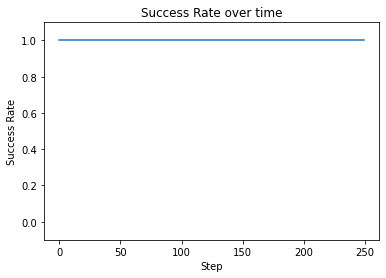

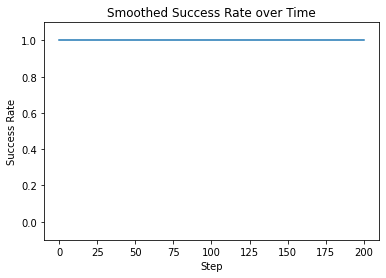

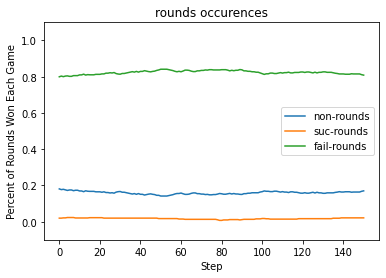

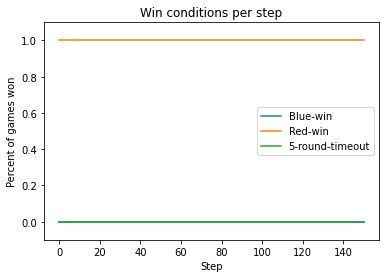

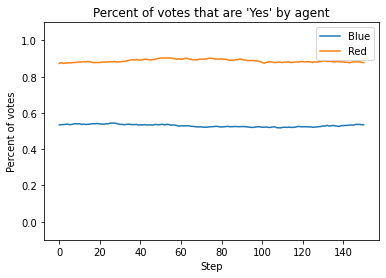

/opt/homebrew/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch 1 - loss = 0.680044949054718, last - 0.6620932221412659
epoch 2 - loss = 0.6807552576065063, last - 0.6692114472389221
epoch 3 - loss = 0.6725737452507019, last - 0.6715962290763855
epoch 4 - loss = 0.6657921075820923, last - 0.6514276266098022
epoch 5 - loss = 0.6713419556617737, last - 0.6545042991638184
epoch 6 - loss = 0.6599489450454712, last - 0.6690789461135864
epoch 7 - loss = 0.6458629965782166, last - 0.6104288101196289
epoch 8 - loss = 0.652531087398529, last - 0.5373992323875427
epoch 9 - loss = 0.6535983681678772, last - 0.5848621129989624
epoch 10 - loss = 0.6437795758247375, last - 0.7258771657943726
epoch 11 - loss = 0.6351888179779053, last - 0.6260153651237488
epoch 12 - loss = 0.6317532658576965, last - 0.5911102294921875
epoch 13 - loss = 0.6169924139976501, last - 0.5572603344917297
epoch 14 - loss = 0.6256584525108337, last - 0.5459590554237366
epoch 15 - loss = 0.6064280867576599, last - 0.4623495042324066
epoch 16 - loss = 0.589237630367279, last - 0.61329

KeyboardInterrupt: 

In [471]:
# trainable_models=['comm_red', 'comm_blue', 'who_blue', 'miss_red_2', 'miss_red_3', 'miss_blue_2', 'miss_blue_3', 'vote_red', 'vote_blue', 'succ_red']
# trainable_models=['miss_red_2', 'miss_red_3', 'comm_red', 'vote_red', 'succ_red']
trainable_models=['comm_blue', 'who_blue', 'miss_blue_2', 'miss_blue_3', 'vote_blue',]

# trainable_models=['who_blue']
# trainable_models=['comm_blue']

set_random_seed(2)

lrs_blue = {'COMM':0.00025, 'WHO':0.003, 'MISS2':0.00025, 'MISS3':0.00025, 'VOTE':0.00025}
lrs_red = {'COMM':0.00025, 'SUCC':0.00025, 'MISS2':0.00025, 'MISS3':0.00025, 'VOTE':0.00025}
gamma = 0.99
gae_lambda = 0.95

blue = BlueAgent(lrs=lrs_blue, use_critic=args["use_critic"])
# blue = BlueAgentBaselineWHO(lrs=lrs_blue, use_critic=args["use_critic"]) # BlueAgentBaseline()
# red = RedAgent(lrs=lrs_red, use_critic=args["use_critic"])
red = RedAgentBaseline(use_critic=args["use_critic"])

my_env = AvalonEnv()
engine = AvalonEngine(env=my_env, blue=blue, red=red, train_episodes=50, max_epoch=1000,
                      trainable_models=trainable_models, gamma=gamma, gae_lambda=gae_lambda)
hist_log, winning_log, every_log = engine.run(is_training=True, plot=True)
evaluate(hist_log, winning_log, every_log)

In [ ]:
%matplotlib inline
evaluate(hist_log, winning_log, every_log)

# Plot detailed events in single round

# Save the model to file

In [ ]:
# dump red and blue agent to file
import os, dill
model_path = 'pretrained_models.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as file:
        pretrained_models = dill.load(file)
else:
    pretrained_models = {}
    
# choose the model name and the corresponding model to save
# pretrained_models[ /// name of the pretrained model /// ] = copy.deepcopy( /// the model class /// )

with open('pretrained_models.pkl', 'wb') as file:
    dill.dump(pretrained_models, file)

pretrained_models

In [ ]:
blue = pretrained_models['blue_against_red_1']
red = pretrained_models['red_against_blue_bl_WHO']

In [ ]:
# #@title
# def compute_advantage_gae(values, discounted_rewards, stepid_replay, gae_lambda, gamma, train_model):
#     rewards = [x if abs(x) == 1 else 0 for x in discounted_rewards]
#     # print(rewards)
#     # print(discounted_rewards)

#     reps = 0
#     if stepid_replay[0] != 0:
#         print(train_model)
#         print(stepid_replay)
#     while stepid_replay[reps] == 0:
#         reps += 1

#     rewards_single = torch.Tensor(rewards[::reps])
#     values_single = torch.Tensor(values[::reps])

#     end_of_epi = np.arange(len(rewards_single))[rewards_single != 0].astype(int)
    
#     # print(end_of_epi)
#     # print(values_single)

#     last_end = -1
#     total_advs = []
#     for end in end_of_epi:
#         # calculate advantage_gae from index last_end+1 ~ end\
#         theta = rewards_single[last_end+1:end+1] - values_single[last_end+1:end+1]
#         theta[:-1] += gamma * values_single[last_end+2:end+1]
#         gl = gamma * gae_lambda
#         advantages = torch.tensor([
#             (theta[i:] * (gl ** torch.arange(end - last_end -i))).sum() for i in range(end - last_end)
#         ])

#         # print(f'last_end: {last_end} ~ end: {end} => {len(advantages)}')
#         # print(advantages)
#         total_advs.append(advantages)
#         last_end = end
#     ############################################################################
    
#     total_advs = torch.concat(total_advs)
#     torch.repeat_interleave(total_advs, 2)

#     # print(total_advs)
#     # print(torch.repeat_interleave(total_advs, 2))
#     # assert 0

#     return total_advs